# E-commerce Dataset Analytics

# Initializing & Importing Used Library

In [ ]:
# Install PySpark for Google CoLab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
print('[Done] openjdk8 has been installed')
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz -C /usr/lib/
!rm spark-2.4.7-bin-hadoop2.7.tgz
print('[Done] Spark has been installed')
!pip install -q findspark
print('[Done] findspark has been installed')
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/lib/spark-2.4.7-bin-hadoop2.7"
print('[Done] Environment variables has been set')
import findspark
findspark.init()
print('[Done] You can use pyspark now.')

[Done] openjdk8 has been installed
[Done] Spark has been installed
[Done] findspark has been installed
[Done] Environment variables has been set
[Done] You can use pyspark now.


In [ ]:
# Import Libraries
from pyspark.sql import SparkSession
from mlxtend.frequent_patterns import apriori,association_rules
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

In [ ]:
# Create Spark Session
spark = SparkSession.builder.getOrCreate()

# **Importing The Dataset**

The dataset is in csv format. To import this dataset, we use spark so that we can easily generate query based on the dataset.



In [ ]:
from pyspark.sql.types import DoubleType, TimestampType, StringType, StructField, StructType, IntegerType

transactionSchema = StructType([
    StructField("InvoiceNo", StringType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", TimestampType(), True),
    StructField("UnitPrice", DoubleType(), True),
    StructField("CustomerID", IntegerType(), True),
    StructField("Country", StringType(), True)])

invoiceDateFormat = "dd/MM/yyyyy HH:mm"
dataset = spark.read.csv('online retail.csv', header=True, schema = transactionSchema, timestampFormat= invoiceDateFormat)

# **Exploring and Cleaning The Dataset**

The dataset contains 541909 rows and some column, such as Description and CustomerID contain null values. We will deal with that later.

Exploration:


1.   InvoiceNo <br>
  InvoiceNo indicates a unique ID of a transaction. If two or more rows have the same InvoiceNo, that means all of those rows belong to one transaction and the transaction contains multiple item sold. 

  InvoiceNo consists of 6 digit. However, if it starts with 'C', it means the transaction is cancelled. We will deal with this later
2.   StockCode <br>
StockCode is a unique identifier for each item sold. It consists of 5 digit.
  
  Some StockCode doesn't follow the 5 digit template because they are a unique non sellable items, such as 'AMAZONFEE', 'POST', 'gift_0001', etc. The purpose is to add detail to the transaction.
3.   Description <br>
It describes the name of item sold. There is no specification for description, it can be either short or long.
4.  Quantity <br>
Quantity specifies how much the customer buy for a specified item in a specified transaction.
  
  Some transactions are having negative quantity, which is invalid. The quantity should always be greater or equal to one. We will deal with this later.

5.   InvoiceDate <br>
This specifies when the transaction happened. This InvoiceDate has a minute-level accuracy.

6.   UnitPrice <br>
UnitPrice describes how much an item costs in Pound sterling (£).
  
  Some UnitPrice are negative. The quantity should always be greater than 0. We will deal with this later.
7.   CustomerID <br>
CustomerID describes which customer is creating the transaction.
  
  There are so many rows having null values. However, it could mean that the one creating the transaction is a guest user that didn't have a customerID. So, the null value should be ignored or changed to 'guest'.
8.   Country <br>
Country indicates where the customer address is.

Example: in row 1-7, the InvoiceNo is 536365 and the customerID is 17850, that means the customer with customerID 17850 created a transaction that contains 7 items.



In [ ]:
dataset.summary().show()
dataset.show(truncate=False)
dataset.registerTempTable('transaction')

+-------+-----------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|summary|        InvoiceNo|         StockCode|         Description|          Quantity|        UnitPrice|        CustomerID|    Country|
+-------+-----------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|  count|           541909|            541909|              540455|            541909|           541909|            406829|     541909|
|   mean| 559965.752026781|27623.240210938104|             20713.0|  9.55224954743324|4.611113626082961|15287.690570239585|       null|
| stddev|13428.41728080439|16799.737628427712|                 NaN|218.08115785023486|96.75985306117956| 1713.600303321589|       null|
|    min|           536365|             10002| 4 PURPLE FLOCK D...|            -80995|        -11062.06|             12346|  Australia|
|    25%|         547903.0|           21929.0|  

## **1. Removing Cancelled Order (InvoiceNo)**

Here are the rows which belongs to cancelled order (invoiceNo starting with 'C')

In [ ]:
# show cancelled order
spark.sql(
    '''
    SELECT * FROM Transaction
    WHERE InvoiceNo like 'C%'
    '''
).show(50,truncate = False)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|C536379  |D        |Discount                           |-1      |2010-01-12 09:41:00|27.5     |14527     |United Kingdom|
|C536383  |35004C   |SET OF 3 COLOURED  FLYING DUCKS    |-1      |2010-01-12 09:49:00|4.65     |15311     |United Kingdom|
|C536391  |22556    |PLASTERS IN TIN CIRCUS PARADE      |-12     |2010-01-12 10:24:00|1.65     |17548     |United Kingdom|
|C536391  |21984    |PACK OF 12 PINK PAISLEY TISSUES    |-24     |2010-01-12 10:24:00|0.29     |17548     |United Kingdom|
|C536391  |21983    |PACK OF 12 BLUE PAISLEY TISSUES    |-24     |2010-01-12 10:24:00|0.29     |17548     |United Kingdom|
|C536391  |21980

To remove the cancelled order, we take everything which InvoiceNo is not started with 'C'.

In [ ]:
# remove cancelled order
dataset = spark.sql(
    '''
    SELECT * FROM Transaction
    WHERE InvoiceNo NOT like 'C%'
    ORDER BY Quantity
    '''
)

dataset.show(50,truncate = False)
#dataset.summary().show()

dataset.registerTempTable('Transaction')

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|556691   |23005    |printing smudges/thrown away       |-9600   |2012-02-06 10:37:00|0.0      |null      |United Kingdom|
|556690   |23005    |printing smudges/thrown away       |-9600   |2012-02-06 10:37:00|0.0      |null      |United Kingdom|
|556687   |23003    |Printing smudges/thrown away       |-9058   |2012-02-06 10:36:00|0.0      |null      |United Kingdom|
|546152   |72140F   |throw away                         |-5368   |2011-09-03 17:25:00|0.0      |null      |United Kingdom|
|573596   |79323W   |Unsaleable, destroyed.             |-4830   |2013-07-10 15:17:00|0.0      |null      |United Kingdom|
|566768   |16045

## **2. Removing Invalid StockCode**

A valid StockCode should at least contains 5 consecutive digits, such as '12345', '12345A', etc. Otherwise it is invalid. Here are list of invalid StockCodes:

In [ ]:
# showing non-item stockCode
spark.sql(
    '''
    SELECT StockCode as `Non-item (Invalid) Stock Code`, Description, COUNT(*) AS `Total Occurances`
    FROM Transaction
    WHERE StockCode NOT REGEXP '[0-9]{5}'
    GROUP BY StockCode, Description
    ORDER BY StockCode

    '''
).show(100)

+-----------------------------+--------------------+----------------+
|Non-item (Invalid) Stock Code|         Description|Total Occurances|
+-----------------------------+--------------------+----------------+
|                    AMAZONFEE|          AMAZON FEE|               2|
|                            B|     Adjust bad debt|               3|
|                 BANK CHARGES|        Bank Charges|              12|
|                           C2|                null|               1|
|                           C2|            CARRIAGE|             141|
|                     DCGS0003| BOXED GLASS ASHTRAY|               4|
|                     DCGS0003|                ebay|               1|
|                     DCGS0004|HAYNES CAMPER SHO...|               1|
|                     DCGS0055|                null|               1|
|                     DCGS0057|                null|               1|
|                    DCGS0066P|                null|               1|
|                   

To remove it, we use regex to select only valid StockCode

In [ ]:
# remove invalid stock code

dataset = spark.sql(
    '''
    SELECT *
    FROM Transaction
    WHERE StockCode REGEXP '[0-9]{5}'
    '''
)

dataset.show(50,truncate = False)
#dataset.summary().show()

dataset.registerTempTable('Transaction')

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|556691   |23005    |printing smudges/thrown away       |-9600   |2012-02-06 10:37:00|0.0      |null      |United Kingdom|
|556690   |23005    |printing smudges/thrown away       |-9600   |2012-02-06 10:37:00|0.0      |null      |United Kingdom|
|556687   |23003    |Printing smudges/thrown away       |-9058   |2012-02-06 10:36:00|0.0      |null      |United Kingdom|
|546152   |72140F   |throw away                         |-5368   |2011-09-03 17:25:00|0.0      |null      |United Kingdom|
|573596   |79323W   |Unsaleable, destroyed.             |-4830   |2013-07-10 15:17:00|0.0      |null      |United Kingdom|
|566768   |16045

## **3. Removing Invalid Quantity**

In this step, we remove every quantity which is negative or zero

In [ ]:
# showing invalid Quantity
spark.sql(
    '''
    SELECT *
    FROM Transaction
    WHERE Quantity <=0
    '''
).show(50)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   556691|    23005|printing smudges/...|   -9600|2012-02-06 10:37:00|      0.0|      null|United Kingdom|
|   556690|    23005|printing smudges/...|   -9600|2012-02-06 10:37:00|      0.0|      null|United Kingdom|
|   556687|    23003|Printing smudges/...|   -9058|2012-02-06 10:36:00|      0.0|      null|United Kingdom|
|   546152|   72140F|          throw away|   -5368|2011-09-03 17:25:00|      0.0|      null|United Kingdom|
|   573596|   79323W|Unsaleable, destr...|   -4830|2013-07-10 15:17:00|      0.0|      null|United Kingdom|
|   566768|    16045|                null|   -3667|2012-02-09 17:53:00|      0.0|      null|United Kingdom|
|   565304|    16259|       

In [ ]:
# remove invalid quantity
dataset = spark.sql(
    '''
    SELECT * FROM Transaction
    WHERE Quantity >0
    '''
)

dataset.show(50,truncate = False)
#dataset.summary().show()

dataset.registerTempTable('Transaction')

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|563026   |22383    |LUNCH BAG SUKI DESIGN              |1       |2011-11-08 14:04:00|1.65     |15747     |United Kingdom|
|563093   |21080    |SET/20 RED RETROSPOT PAPER NAPKINS |1       |2011-11-08 17:28:00|1.63     |null      |United Kingdom|
|563026   |23201    |JUMBO BAG ALPHABET                 |1       |2011-11-08 14:04:00|2.08     |15747     |United Kingdom|
|563023   |22847    |BREAD BIN DINER STYLE IVORY        |1       |2011-11-08 13:39:00|16.95    |14639     |United Kingdom|
|563026   |22662    |LUNCH BAG DOLLY GIRL DESIGN        |1       |2011-11-08 14:04:00|1.65     |15747     |United Kingdom|
|563022   |21246

## **4. Removing Invalid UnitPrice**

UnitPrice is invalid if it's zero or negative.

In [ ]:
# showing invalid Unit Price
spark.sql(
    '''
    SELECT *
    FROM Transaction
    WHERE UnitPrice <= 0
    ORDER BY UnitPrice
    '''
).show(50)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   563101|    22084|                null|       1|2011-12-08 10:07:00|      0.0|      null|United Kingdom|
|   563102|    21359|                null|       1|2011-12-08 10:07:00|      0.0|      null|United Kingdom|
|   563105|    22194|                null|       2|2011-12-08 10:15:00|      0.0|      null|United Kingdom|
|   563106|    21658|                null|       3|2011-12-08 10:15:00|      0.0|      null|United Kingdom|
|   563108|    21033|                null|      37|2011-12-08 10:18:00|      0.0|      null|United Kingdom|
|   563359|    23084|                null|      20|2012-03-08 14:56:00|      0.0|      null|United Kingdom|
|   563445|   85049D|       

So, we take the row only if the unit price is greater than 0.

In [ ]:
# remove invalid unit price

dataset = spark.sql(
    '''
    SELECT *
    FROM Transaction
    WHERE UnitPrice >0
    '''
)
dataset.show(50,truncate = False)
#dataset.summary().show()

dataset.registerTempTable('Transaction')

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|563026   |22383    |LUNCH BAG SUKI DESIGN              |1       |2011-11-08 14:04:00|1.65     |15747     |United Kingdom|
|563093   |21080    |SET/20 RED RETROSPOT PAPER NAPKINS |1       |2011-11-08 17:28:00|1.63     |null      |United Kingdom|
|563026   |23201    |JUMBO BAG ALPHABET                 |1       |2011-11-08 14:04:00|2.08     |15747     |United Kingdom|
|563023   |22847    |BREAD BIN DINER STYLE IVORY        |1       |2011-11-08 13:39:00|16.95    |14639     |United Kingdom|
|563026   |22662    |LUNCH BAG DOLLY GIRL DESIGN        |1       |2011-11-08 14:04:00|1.65     |15747     |United Kingdom|
|563022   |21246

## **5. Removing Invalid CustomerID**

CustomerID consists of 5 digits, other than that it's invalid. We can check the invalid CustomerID using regex

In [ ]:
# showing invalid CustomerID
spark.sql(
    '''
    SELECT *
    FROM Transaction
    WHERE CustomerID NOT REGEXP '[0-9]{5}'
    '''
).show(50)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Apparently there's no invalid customerID, so we don't need to fix it.

## **6. Dealing with null value**

In [ ]:
dataset.summary().show()

+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|  count|            527725|            527725|              527725|            527725|           527725|            396337|     527725|
|   mean|   559988.47279928|27591.351654656588|                null|10.567996589132598|3.265319550902714|15301.689415825422|       null|
| stddev|13432.709397385319| 16756.84865810657|                null|155.83927407648144|4.377915398919684|1709.9619478195393|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|                 1|             0.04|             12346|  Australia|
|    25%|          547910.0|           21

As shown above, after all the removal processes, the dataset contains 527725. All attributes except CustomerID have no null value. Here are the rows which customerID is null:

In [ ]:
# showing null row
spark.sql(
    '''
    SELECT *
    FROM Transaction
    WHERE 
    CustomerID IS NULL
    '''
).show(50)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   563093|    22322|BIRD DECORATION G...|       1|2011-11-08 17:28:00|     1.63|      null|United Kingdom|
|   563093|    23203|JUMBO BAG VINTAGE...|       1|2011-11-08 17:28:00|     4.13|      null|United Kingdom|
|   563093|    22362|GLASS JAR PEACOCK...|       1|2011-11-08 17:28:00|     5.79|      null|United Kingdom|
|   563027|    23169|CLASSIC GLASS COO...|       1|2011-11-08 14:10:00|     4.15|      null|United Kingdom|
|   563093|    22364|GLASS JAR DIGESTI...|       1|2011-11-08 17:28:00|     5.79|      null|United Kingdom|
|   563088|    22832|BROCANTE SHELF WI...|       1|2011-11-08 16:51:00|    10.75|      null|United Kingdom|
|   563093|    22366|    DOO

There are around 120,000 rows which has null CustomerID. 

**However, null here means that the transaction is created by a guest (non logged-in Customer), so we can just leave it as it is.**

# **Descriptive Analytics: Sales Report Using Statistics**

Descriptive analytics invovle analyzing and summarizing past data so that it can be easily interpreted by the reader. Descriptive analytics aims to answer 'What has ahppened?'.

In this section, we want to answer the following questions using simple statistic and visualize it using matplotlib:

1.   What is the total number of items sold each month?
2.   What is the total revenue for each month?
3.   What is the total sales for each item?
4.   What is the total revenue generated by each item?

This analytics is useful to get the general information on what happened on the e-commerce, which in turn could be used to determine future decision for the stakeholders.



## **1. Monthly Sales (What is the total number of items sold each month?)**

We can easily obtain this information by using query on our dataset.

In [ ]:
res = spark.sql(
    '''
    SELECT 
    CONCAT_WS( ' ',
    (
      CASE
      WHEN month = 1 THEN 'January'
      WHEN month = 2 THEN 'February'
      WHEN month = 3 THEN 'March'
      WHEN month = 4 THEN 'April'
      WHEN month = 5 THEN 'May'
      WHEN month = 6 THEN 'June'
      WHEN month = 7 THEN 'July'
      WHEN month = 8 THEN 'August'
      WHEN month = 9 THEN 'September'
      WHEN month = 10 THEN 'October'
      WHEN month = 11 THEN 'November'
      WHEN month = 12 THEN 'December'
      END
    ), year) AS `Month`,
    SUM(item_sold) AS `Monthly Item Sold (pcs)`
    FROM(
      SELECT MONTH(InvoiceDate) AS month, YEAR(InvoiceDate) AS year, StockCode, Description, SUM(Quantity) AS `item_sold`
      FROM Transaction
      GROUP BY YEAR(InvoiceDate), MONTH(InvoiceDate), StockCode, Description
      ORDER BY YEAR(InvoiceDate), MONTH(InvoiceDate)
    ) AS t
    GROUP BY year, t.month
    ORDER BY year, t.month
    '''
)

res.show(100)

+--------------+-----------------------+
|         Month|Monthly Item Sold (pcs)|
+--------------+-----------------------+
|  January 2010|                  26909|
| February 2010|                  31327|
|    March 2010|                  16177|
|      May 2010|                  16371|
|     June 2010|                  21768|
|     July 2010|                  25200|
|   August 2010|                  23066|
|September 2010|                  19895|
|  October 2010|                  21063|
| December 2010|                  10603|
|  January 2011|                 169622|
| February 2011|                 153085|
|    March 2011|                 159197|
|    April 2011|                 237037|
|      May 2011|                 231339|
|     June 2011|                 192088|
|     July 2011|                 218225|
|   August 2011|                 189495|
|September 2011|                 256650|
|  October 2011|                 162431|
| November 2011|                 220698|
| December 2011|

In [ ]:
res = res.toPandas()

Then, let's visualize it so that it's easier to interpret

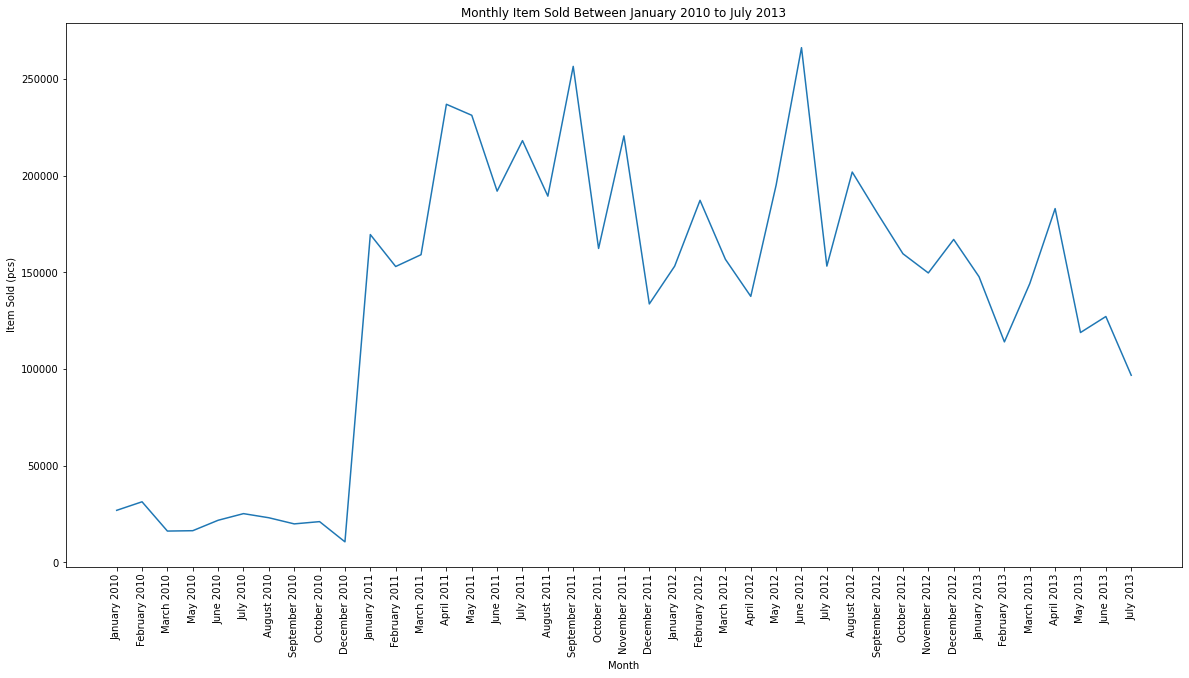

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(res['Monthly Item Sold (pcs)'])
plt.title('Monthly Item Sold Between January 2010 to July 2013')
plt.xticks( range(0, len(res['Month']) ), res['Month'], rotation=90)
plt.xlabel('Month')
plt.ylabel('Item Sold (pcs)')
plt.show()

Based on the graph above, we could obtain several informations:



*   The total sales increased a lot from December 2010 to January 2021, perhaps it's due to past company decision on marketing, sales, etc.
*   June 2012 is the month with the most sales with 266.338 items sold in total.
*   The average monthly sales were decreasing in 2013



## **2. Monthly Revenue (What is the total revenue for each month?)**

To answer this question, we can apply query directly on our dataset

In [ ]:
res1 = spark.sql(
    '''
    SELECT 
    CONCAT_WS( ' ',
    (
      CASE
      WHEN month = 1 THEN 'January'
      WHEN month = 2 THEN 'February'
      WHEN month = 3 THEN 'March'
      WHEN month = 4 THEN 'April'
      WHEN month = 5 THEN 'May'
      WHEN month = 6 THEN 'June'
      WHEN month = 7 THEN 'July'
      WHEN month = 8 THEN 'August'
      WHEN month = 9 THEN 'September'
      WHEN month = 10 THEN 'October'
      WHEN month = 11 THEN 'November'
      WHEN month = 12 THEN 'December'
      END
    ), year) AS `Month`,
    ROUND(SUM(item_revenue), 2) AS `Monthly Gross Revenue (£)`
    FROM(
      SELECT MONTH(InvoiceDate) AS month, YEAR(InvoiceDate) AS year, StockCode, SUM(Quantity) * UnitPrice AS `item_revenue`
      FROM Transaction
      GROUP BY YEAR(InvoiceDate), MONTH(InvoiceDate), StockCode, UnitPrice
      ORDER BY YEAR(InvoiceDate), MONTH(InvoiceDate)
    )
    GROUP BY year, month
    ORDER BY year, month
    '''
)

res1.show(100)

+--------------+-------------------------+
|         Month|Monthly Gross Revenue (£)|
+--------------+-------------------------+
|  January 2010|                 57626.33|
| February 2010|                 47715.38|
|    March 2010|                 44833.98|
|      May 2010|                 31318.99|
|     June 2010|                 51873.43|
|     July 2010|                 81519.34|
|   August 2010|                  44308.6|
|September 2010|                 50014.38|
|  October 2010|                 56847.52|
| December 2010|                 17329.07|
|  January 2011|                291417.06|
| February 2011|                294184.52|
|    March 2011|                297844.06|
|    April 2011|                419493.24|
|      May 2011|                407120.99|
|     June 2011|                337259.81|
|     July 2011|                 428252.1|
|   August 2011|                 359957.7|
|September 2011|                501506.23|
|  October 2011|                333337.13|
| November 

In [ ]:
res1 = res1.toPandas()

Then, visualize it using matplotlib

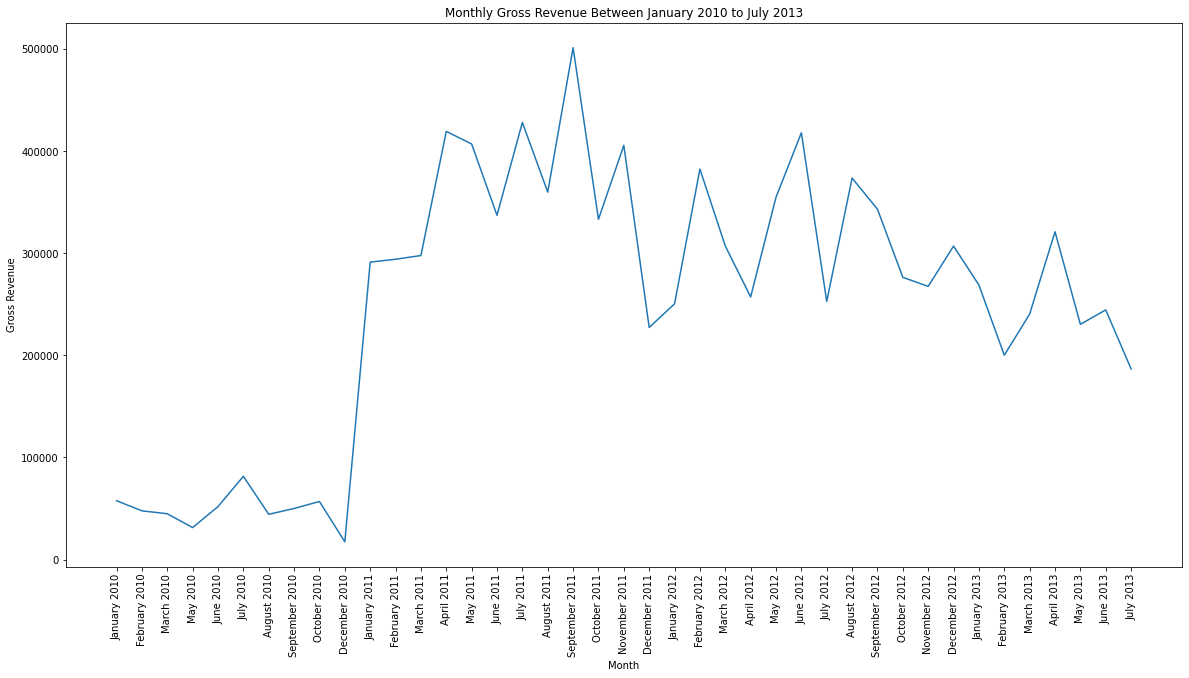

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(res1['Monthly Gross Revenue (£)'])
plt.title('Monthly Gross Revenue Between January 2010 to July 2013')
plt.xticks( range(0, len(res1['Month']) ), res1['Month'], rotation=90)
plt.xlabel('Month')
plt.ylabel('Gross Revenue')
plt.show()

Based on the graph above, we could obtain several informations:


*   The monthly revenue increased a lot from December 2010 to January 2021, perhaps it's due to past company decision on marketing, sales, etc.
*   Although June 2012 is the month with the most sales, September 2011 is the month with the most revenue (£501,506.23)
*   The average monthly revenue were decreasing in 2013



## **3. Item Sales (What is the total sales for each item?)**

Next, we want to search which item is the best seller in our commerce

In [ ]:
# showing Total Item sold
res = spark.sql(
    '''
    SELECT Description, SUM(Quantity) AS `Total Sold`
    FROM Transaction
    GROUP BY StockCode, Description
    ORDER BY `Total Sold` DESC
    '''
)
total_items = res.groupBy().count().collect()[0][0]
total_sold_all = res.groupBy().sum().collect()[0][0]
print("Total items available: ", total_items)
print("Total item sold so far: " , total_sold_all)

res.show(100, truncate=False)

Total items available:  4139
Total item sold so far:  5576996
+-----------------------------------+----------+
|Description                        |Total Sold|
+-----------------------------------+----------+
|PAPER CRAFT , LITTLE BIRDIE        |80995     |
|MEDIUM CERAMIC TOP STORAGE JAR     |78033     |
|WORLD WAR 2 GLIDERS ASSTD DESIGNS  |55047     |
|JUMBO BAG RED RETROSPOT            |48474     |
|WHITE HANGING HEART T-LIGHT HOLDER |37599     |
|POPCORN HOLDER                     |36761     |
|ASSORTED COLOUR BIRD ORNAMENT      |36461     |
|PACK OF 72 RETROSPOT CAKE CASES    |36419     |
|RABBIT NIGHT LIGHT                 |30788     |
|MINI PAINT SET VINTAGE             |26633     |
|PACK OF 12 LONDON TISSUES          |26135     |
|PACK OF 60 PINK PAISLEY CAKE CASES |24854     |
|VICTORIAN GLASS HANGING T-LIGHT    |24304     |
|ASSORTED COLOURS SILK FAN          |23826     |
|BROCADE RING PURSE                 |23056     |
|RED  HARMONICA IN BOX              |21933     |
|JUMBO 

Next, visualize the data using matplotlib. But, because the number of items is too big to visualize (4139 items), we take only the top 100 sold items.

Additionally, we calculate the cumulative amount of items sold to gain more insight.

In [ ]:
res = res.toPandas()
res = res.truncate(0,99)

In [ ]:
res['Cumulative Sold'] = res['Total Sold'].cumsum()
res['Percent of Cumulative Sold'] = res['Cumulative Sold']/total_sold_all*100
res.head(100)

,Description,Total Sold,Cumulative Sold,Percent of Cumulative Sold
0,"PAPER CRAFT , LITTLE BIRDIE",80995,80995,1.452305
1,MEDIUM CERAMIC TOP STORAGE JAR,78033,159028,2.851499
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047,214075,3.838536
3,JUMBO BAG RED RETROSPOT,48474,262549,4.707714
4,WHITE HANGING HEART T-LIGHT HOLDER,37599,300148,5.381894
...,...,...,...,...
95,6 RIBBONS RUSTIC CHARM,9183,1636787,29.348900
96,NATURAL SLATE HEART CHALKBOARD,9172,1645959,29.513362
97,SOLDIERS EGG CUP,9137,1655096,29.677195
98,WOODEN PICTURE FRAME WHITE FINISH,9006,1664102,29.838680


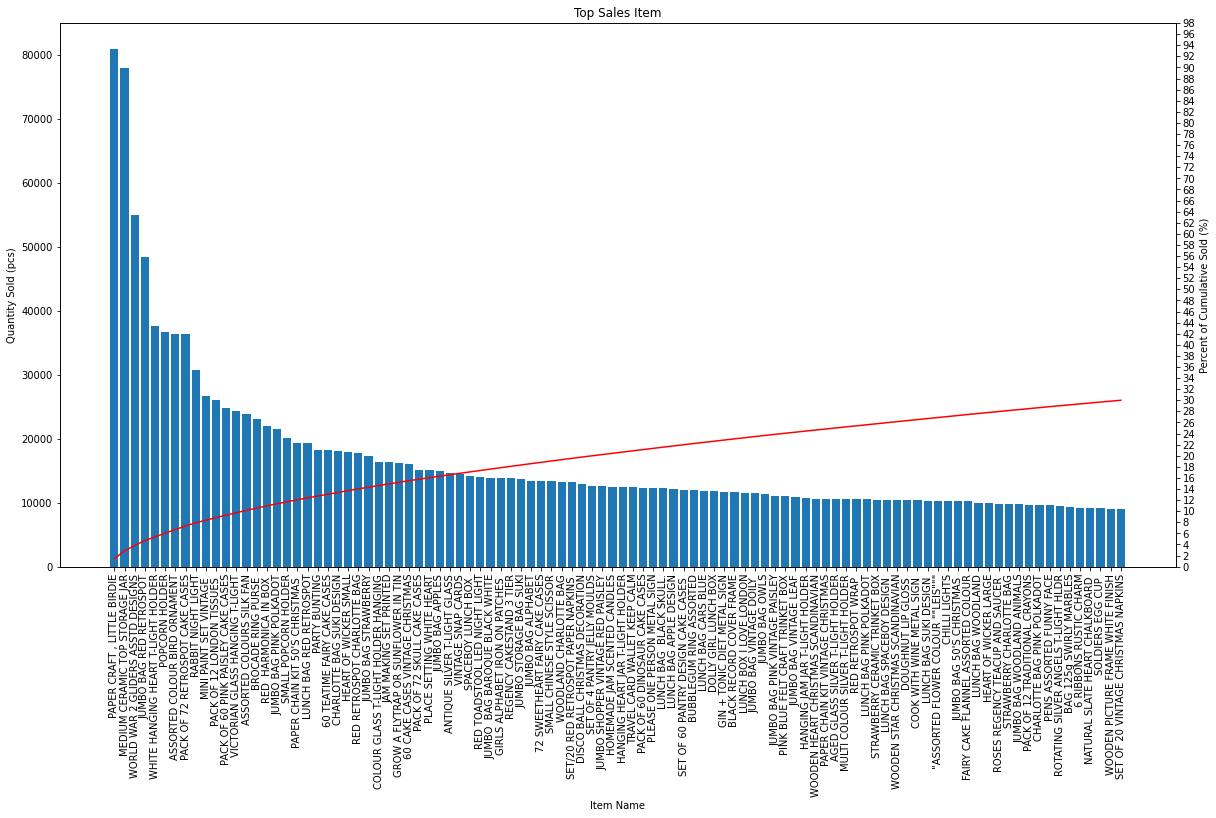

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Top Sales Item')
plt.xlabel('Item Name')
bar = plt.bar(height = res['Total Sold'], x = res['Description'])
plt.ylabel('Quantity Sold (pcs)')
plt.xticks( range(0, len(res['Description']) ), res['Description'], rotation=90)
plt.twinx()
cum = plt.plot(res['Percent of Cumulative Sold'], c = "red")
plt.yticks(np.arange(0, 100, 2))
plt.ylabel('Percent of Cumulative Sold (%)')
plt.show()

As shown on graph above, the top sales item in our e-commerce is 'PAPER CRAFT, LITTLE BIRDIE' which accounts for 80.995 total item sold. 

Surprisingly the TOP 10 sold item (top 0.24%) accounts for 467,210 item sales, which is around 8% of our total sales. The TOP 100 sold items (top 2,4%) accounts for 1,673,089 	item sales, which is 30% of our total sales. This statistics is somewhat following the pareto (80/20) principle.

## **4. Item Revenue (What is the total revenue generated by each item?)**

Next, we want to search which item generates most revenue for our e-commerce

In [ ]:
# showing Total Revenue
res = spark.sql(
    '''
    SELECT Description, SUM(Quantity) AS `Total Sold`, UnitPrice, ROUND(SUM(Quantity)* UnitPrice, 2) AS `Gross Revenue (£)`
    FROM Transaction
    GROUP BY Description, UnitPrice
    ORDER BY `Gross Revenue (£)` DESC
    '''
)
total_revenue_all = res.groupBy().sum().collect()[0][0]
print("Total revenue so far: £ " , total_sold_all)

res.show(100, truncate=False)

Total revenue so far: £  5576996
+-----------------------------------+----------+---------+-----------------+
|Description                        |Total Sold|UnitPrice|Gross Revenue (£)|
+-----------------------------------+----------+---------+-----------------+
|PAPER CRAFT , LITTLE BIRDIE        |80995     |2.08     |168469.6         |
|REGENCY CAKESTAND 3 TIER           |8515      |10.95    |93239.25         |
|MEDIUM CERAMIC TOP STORAGE JAR     |76087     |1.04     |79130.48         |
|WHITE HANGING HEART T-LIGHT HOLDER |19998     |2.55     |50994.9          |
|REGENCY CAKESTAND 3 TIER           |3984      |12.75    |50796.0          |
|PICNIC BASKET WICKER 60 PIECES     |61        |649.5    |39619.5          |
|ASSORTED COLOUR BIRD ORNAMENT      |22533     |1.69     |38080.77         |
|RABBIT NIGHT LIGHT                 |20009     |1.79     |35816.11         |
|BLACK RECORD COVER FRAME           |10372     |3.39     |35161.08         |
|JUMBO BAG RED RETROSPOT            |19136 

Next, visualize the data using matplotlib. But, because the number of items is too big to visualize (4139 items), we take only the top 100 sold items.

Additionally, we calculate the cumulative gross revenue to gain more insight.

In [ ]:
res = res.toPandas()
res = res.truncate(0,99)

In [ ]:
res['Cumulative Revenue'] = res['Gross Revenue (£)'].cumsum()
res['Percent of Cumulative Revenue'] = res['Cumulative Revenue']/total_revenue_all*100
res.head(100)

,Description,Total Sold,UnitPrice,Gross Revenue (£),Cumulative Revenue,Percent of Cumulative Revenue
0,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,168469.60,168469.60,3.020795
1,REGENCY CAKESTAND 3 TIER,8515,10.95,93239.25,261708.85,4.692649
2,MEDIUM CERAMIC TOP STORAGE JAR,76087,1.04,79130.48,340839.33,6.111522
3,WHITE HANGING HEART T-LIGHT HOLDER,19998,2.55,50994.90,391834.23,7.025901
4,REGENCY CAKESTAND 3 TIER,3984,12.75,50796.00,442630.23,7.936714
...,...,...,...,...,...,...
95,WOODEN PICTURE FRAME WHITE FINISH,3869,2.55,9865.95,1868921.62,33.511260
96,GREEN REGENCY TEACUP AND SAUCER,3329,2.95,9820.55,1878742.17,33.687350
97,PACK OF 72 RETROSPOT CAKE CASES,17852,0.55,9818.60,1888560.77,33.863405
98,JUMBO BAG ALPHABET,5460,1.79,9773.40,1898334.17,34.038650


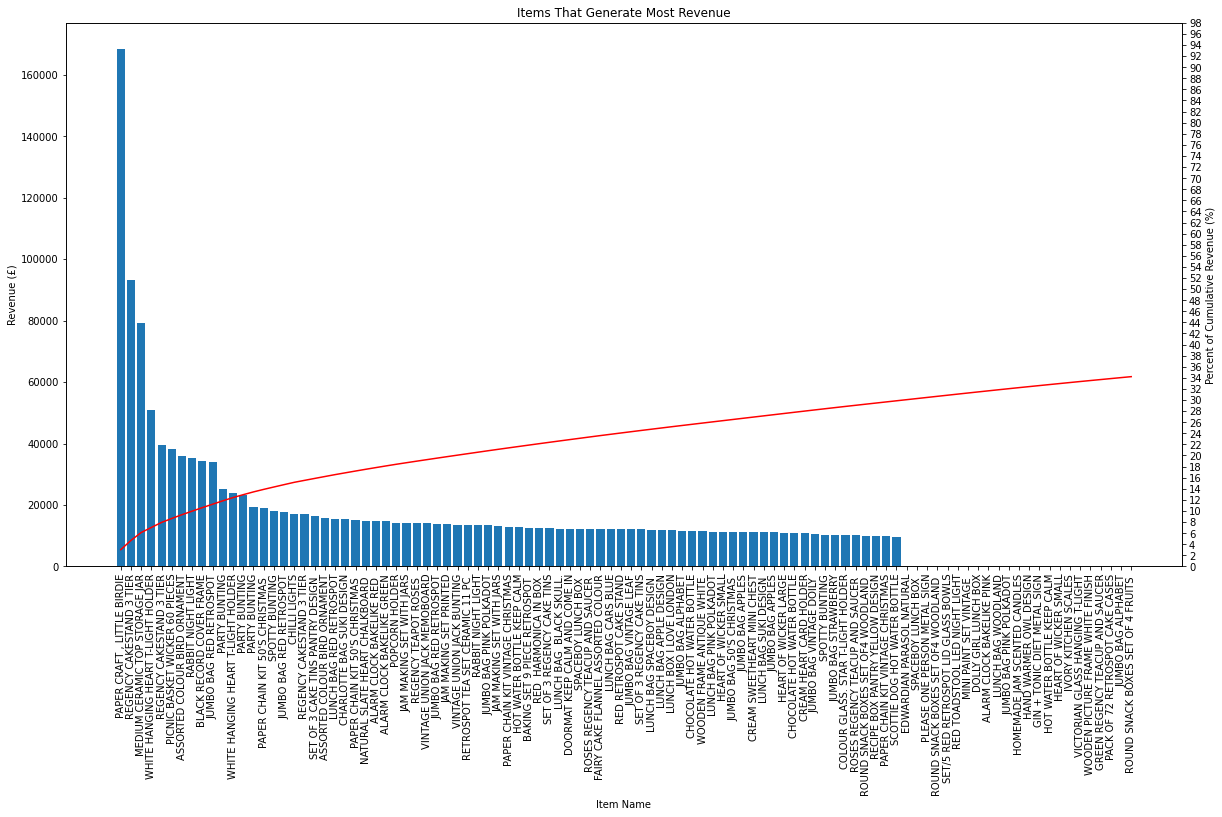

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Items That Generate Most Revenue')
plt.xlabel('Item Name')
bar = plt.bar(height = res['Gross Revenue (£)'], x = res['Description'])
plt.ylabel( 'Revenue (£)')
plt.xticks( range(0, len(res['Description']) ), res['Description'], rotation=90)
plt.twinx()
cum = plt.plot(res['Percent of Cumulative Revenue'], c = "red")
plt.yticks(np.arange(0, 100, 2))
plt.ylabel('Percent of Cumulative Revenue (%)')
plt.show()

As shown on graph above, the item that generated most revenue in our e-commerce is 'PAPER CRAFT, LITTLE BIRDIE' which generates £168,469.60 revenue. 

Surprisingly the TOP 10 items (top 0.24%) generate £625,561.13 revenue, which is around 11% of the total revenue. The TOP 100 items (top 2,4%) generates £1,908,003.77 revenue, which is 34% of the total revenue! This statistics is somewhat following the pareto (80/20) principle.

# **Predictive Analytics: Product Recommender System Using Association Rule Learning**

Descriptive analytics invovles predicting the likelihood of an event in the future using prediction models.

In this section, we want to answer "What is the most likely item that a customer would buy alongside an existing item in their cart?". For example, if a customer has an item A in their cart, we wanted to find what is the next item that he will most likely put in their cart.

The predictive analysis is then used for recommender system. The most likely item will be recommended to the user. For example, if a customer put item A in their cart, then the most likely item that they will put in their cart is B, so we recommend item B to that customer.

This analytics is useful to generate more income by making the customer buy more items.

The approach that we use is by using Association Rule Learning



## 1. First of all, prepare the dataset.

The dataset has been preprocessed before, we just need to convert it into pandas dataframe

In [ ]:
dataset_pd = dataset.toPandas()
dataset_pd

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536381,71270,PHOTO CLIP LINE,1,2010-01-12 09:41:00,1.25,15311.0,United Kingdom
1,536381,22262,FELT EGG COSY CHICKEN,1,2010-01-12 09:41:00,0.85,15311.0,United Kingdom
2,536381,22637,PIGGY BANK RETROSPOT,1,2010-01-12 09:41:00,2.55,15311.0,United Kingdom
3,536381,21166,COOK WITH WINE METAL SIGN,1,2010-01-12 09:41:00,1.95,15311.0,United Kingdom
4,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,1,2010-01-12 09:41:00,2.95,15311.0,United Kingdom
...,...,...,...,...,...,...,...,...
527720,544612,22053,EMPIRE DESIGN ROSETTE,3906,2012-10-02 10:43:00,0.82,18087.0,United Kingdom
527721,554868,22197,SMALL POPCORN HOLDER,4300,2013-03-05 10:52:00,0.72,13135.0,United Kingdom
527722,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2013-03-10 12:26:00,0.21,12901.0,United Kingdom
527723,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2012-06-01 10:01:00,1.04,12346.0,United Kingdom


##2. Create the transaction table

Next we create a transaction table. In this table, each row represents a single transaction (unique InoiceNo) alongside the items bought in the transaction.

In [ ]:
basket = pd.pivot_table(data=dataset_pd, values='Quantity', index='InvoiceNo', columns='Description', aggfunc='sum', fill_value=0)
basket

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,"""ASSORTED FLOWER COLOUR """"LEIS""""""","""CHARLIE+LOLA""""EXTREMELY BUSY"""" SIGN""","""FLOWER GLASS GARLAND NECKL.36""""BLACK""","""FLOWER GLASS GARLAND NECKL.36""""BLUE""","""FLOWER GLASS GARLAND NECKL.36""""GREEN""","""FLOWER GLASS GARLD NECKL36""""AMETHYST""","""FLOWER GLASS GARLD NECKL36""""TURQUOIS""","""LETTER """"A"""" BLING KEY RING""","""LETTER """"B"""" BLING KEY RING""","""LETTER """"C"""" BLING KEY RING""","""LETTER """"D"""" BLING KEY RING""","""LETTER """"E"""" BLING KEY RING""","""LETTER """"F"""" BLING KEY RING""","""LETTER """"G"""" BLING KEY RING""","""LETTER """"H"""" BLING KEY RING""","""LETTER """"I"""" BLING KEY RING""","""LETTER """"J"""" BLING KEY RING""","""LETTER """"K"""" BLING KEY RING""","""LETTER """"L"""" BLING KEY RING""","""LETTER """"M"""" BLING KEY RING""","""LETTER """"N"""" BLING KEY RING""","""LETTER """"O"""" BLING KEY RING""","""LETTER """"P"""" BLING KEY RING""","""LETTER """"R"""" BLING KEY RING""","""LETTER """"S"""" BLING KEY RING""","""LETTER """"T"""" BLING KEY RING""","""LETTER """"U"""" BLING KEY RING""","""LETTER """"V"""" BLING KEY RING""",...,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK CERAMIC CANDLE HOLDER,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,

However, we don't need the quantity of the item bought, we just need to know whether the item was bought or not (True or False).

In [ ]:
# create hot_encode to mark each values in pivot table because we only want to know whether the item was bought or not.
# 1 is bought, 0 is not bought
def hot_encode(x):
    if x > 0:
        return True
    else:
        return False

basket_encoded = basket.applymap(hot_encode)

basket_encoded

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,"""ASSORTED FLOWER COLOUR """"LEIS""""""","""CHARLIE+LOLA""""EXTREMELY BUSY"""" SIGN""","""FLOWER GLASS GARLAND NECKL.36""""BLACK""","""FLOWER GLASS GARLAND NECKL.36""""BLUE""","""FLOWER GLASS GARLAND NECKL.36""""GREEN""","""FLOWER GLASS GARLD NECKL36""""AMETHYST""","""FLOWER GLASS GARLD NECKL36""""TURQUOIS""","""LETTER """"A"""" BLING KEY RING""","""LETTER """"B"""" BLING KEY RING""","""LETTER """"C"""" BLING KEY RING""","""LETTER """"D"""" BLING KEY RING""","""LETTER """"E"""" BLING KEY RING""","""LETTER """"F"""" BLING KEY RING""","""LETTER """"G"""" BLING KEY RING""","""LETTER """"H"""" BLING KEY RING""","""LETTER """"I"""" BLING KEY RING""","""LETTER """"J"""" BLING KEY RING""","""LETTER """"K"""" BLING KEY RING""","""LETTER """"L"""" BLING KEY RING""","""LETTER """"M"""" BLING KEY RING""","""LETTER """"N"""" BLING KEY RING""","""LETTER """"O"""" BLING KEY RING""","""LETTER """"P"""" BLING KEY RING""","""LETTER """"R"""" BLING KEY RING""","""LETTER """"S"""" BLING KEY RING""","""LETTER """"T"""" BLING KEY RING""","""LETTER """"U"""" BLING KEY RING""","""LETTER """"V"""" BLING KEY RING""",...,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK CERAMIC CANDLE HOLDER,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,F

## 3. Generate Itemsets using apriori

In this step, we want to generate all possible itemsets using apriori algorithm. But, if the itemset occurs rarely in our dataset (<0.5% support), then we drop the itemsets. In this case, the maximum size of itemsets is only 2 because the computation requires a lot of computing resources for generating all possible itemsets in 4000s items.

In [ ]:
# make apriori model with min_support 0.005 (0.5%) which means only take the data when items apprear at least 0.5 times from total transaction
frq_items = apriori(basket_encoded, min_support = 0.005 , use_colnames = True, max_len=2)
frq_items.sort_values(by = ['support'], ascending= [False] )

,support,itemsets
1492,0.114095,(WHITE HANGING HEART T-LIGHT HOLDER)
693,0.105649,(JUMBO BAG RED RETROSPOT)
1077,0.100541,(REGENCY CAKESTAND 3 TIER)
916,0.085217,(PARTY BUNTING)
761,0.079098,(LUNCH BAG RED RETROSPOT)
...,...,...
7127,0.005007,"(WOODLAND CHARLOTTE BAG, LUNCH BAG VINTAGE DOI..."
3761,0.005007,"(DOORMAT RED RETROSPOT, JUMBO BAG BAROQUE BLA..."
8522,0.005007,"(RED TOADSTOOL LED NIGHT LIGHT, TRADITIONAL KN..."
3487,0.005007,"(VINTAGE PAISLEY STATIONERY SET, CHRISTMAS TRE..."


## 4. Generate association rules between itemsets

Next, generate all association rules between itemsets. In this process, we want to fouces on the confidence level as the metric. Confidence indicates the likelihood of a customer buying the consequent item if they bought an antecedent item in the past.

For example, if the atecedents is item A and consequents is item B and the confidence is 90%, that means 90% of customer who bought item A also bought item B based on past transactions.

In [ ]:
rules = association_rules(frq_items, metric="confidence", min_threshold= 0.01)
rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6296,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011986,0.012138,0.011177,0.932489,76.825475,0.011031,14.632709
6281,(HERB MARKER CHIVES ),(HERB MARKER PARSLEY),0.010570,0.012037,0.009761,0.923445,76.719653,0.009634,12.905272
6297,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.012138,0.011986,0.011177,0.920833,76.825475,0.011031,12.480176
14122,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.015425,0.019269,0.014060,0.911475,47.303421,0.013762,11.078631
6279,(HERB MARKER CHIVES ),(HERB MARKER MINT),0.010570,0.012138,0.009609,0.909091,74.897727,0.009481,10.866485
...,...,...,...,...,...,...,...,...,...
14502,(WHITE HANGING HEART T-LIGHT HOLDER),(SET OF 12 FAIRY CAKE BAKING CASES),0.114095,0.027917,0.005057,0.044326,1.587795,0.001872,1.017170
15344,(WHITE HANGING HEART T-LIGHT HOLDER),(TOOTHPASTE TUBE PEN),0.114095,0.010368,0.005007,0.043883,4.232674,0.003824,1.035054
13138,(WHITE HANGING HEART T-LIGHT HOLDER),(POLKADOT RAIN HAT ),0.114095,0.011430,0.005007,0.043883,3.839372,0.003703,1.033943
2868,(WHITE HANGING HEART T-LIGHT HOLDER),(CHARLOTTE BAG DOLLY GIRL DESIGN),0.114095,0.020988,0.005007,0.043883,2.090839,0.002612,1.023946


## 5. Recommender System simulation

Let's simulate when someone put an item in their cart:

In [ ]:
#simulation: someone put an item into their cart
random_item = dataset_pd['Description'].sample().values[0]

item_in_cart = set()
item_in_cart.add(random_item)

print('Item put in the cart: ', item_in_cart)

Item put in the cart:  {'60 CAKE CASES DOLLY GIRL DESIGN'}


Next, the item in the cart will be attecedent. So, we search all rows that has the attecedent and sort it by confidence.

Note that if the recommendation list is empty, that means the item was rarely bought, hence we can't make a recommendation based on past transaction data

In [ ]:
recommendations = rules[rules.antecedents == item_in_cart]

recommendations = recommendations.sort_values(['confidence', 'lift'], ascending =[False, False])

recommendations

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
436,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 72 RETROSPOT CAKE CASES),0.022101,0.066758,0.012239,0.553776,8.295309,0.010764,2.091420
432,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 60 PINK PAISLEY CAKE CASES),0.022101,0.043949,0.010519,0.475973,10.830155,0.009548,1.824430
415,(60 CAKE CASES DOLLY GIRL DESIGN),(60 TEATIME FAIRY CAKE CASES),0.022101,0.041875,0.010064,0.455378,10.874614,0.009139,1.759246
434,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 60 SPACEBOY CAKE CASES),0.022101,0.026298,0.009761,0.441648,16.793650,0.009180,1.743883
428,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 60 DINOSAUR CAKE CASES),0.022101,0.030395,0.008496,0.384439,12.648119,0.007825,1.575158
417,(60 CAKE CASES DOLLY GIRL DESIGN),(72 SWEETHEART FAIRY CAKE CASES),0.022101,0.031103,0.007991,0.361556,11.624468,0.007303,1.517591
439,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 72 SKULL CAKE CASES),0.022101,0.033531,0.006726,0.304348,9.076726,0.005985,1.389300
444,(60 CAKE CASES DOLLY GIRL DESIGN),(SET OF 60 PANTRY DESIGN CAKE CASES ),0.022101,0.031811,0.006322,0.286041,8.991880,0.005619,1.356085
430,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 60 MUSHROOM CAKE CASES),0.022101,0.019876,0.006221,0.281465,14.161318,0.005781,1.364058
441,(60 CAKE CASES DOLLY GIRL DESIGN),(REGENCY CAKESTAND 3 TIER),0.022101,0.100541,0.006221,0.281465,2.799496,0.003999,1.251795


Next, list all the recommended item names and its confidence

In [ ]:
recommend_list = pd.DataFrame(columns=['consequents','confidence'])

In [ ]:
for i in range(len(recommendations['consequents'].values[:])):
  recommend_list = recommend_list.append({'consequents':next(iter(recommendations['consequents'].values[i])), 'confidence':recommendations['confidence'].values[i]}, ignore_index=True)

print("List of Recommendations: ")
recommend_list

List of Recommendations: 


,consequents,confidence
0,PACK OF 72 RETROSPOT CAKE CASES,0.553776
1,PACK OF 60 PINK PAISLEY CAKE CASES,0.475973
2,60 TEATIME FAIRY CAKE CASES,0.455378
3,PACK OF 60 SPACEBOY CAKE CASES,0.441648
4,PACK OF 60 DINOSAUR CAKE CASES,0.384439
5,72 SWEETHEART FAIRY CAKE CASES,0.361556
6,PACK OF 72 SKULL CAKE CASES,0.304348
7,SET OF 60 PANTRY DESIGN CAKE CASES,0.286041
8,PACK OF 60 MUSHROOM CAKE CASES,0.281465
9,REGENCY CAKESTAND 3 TIER,0.281465


Lastly, we can visualize the recommended items alongside their confidence. Higher confidence means more recommended. 

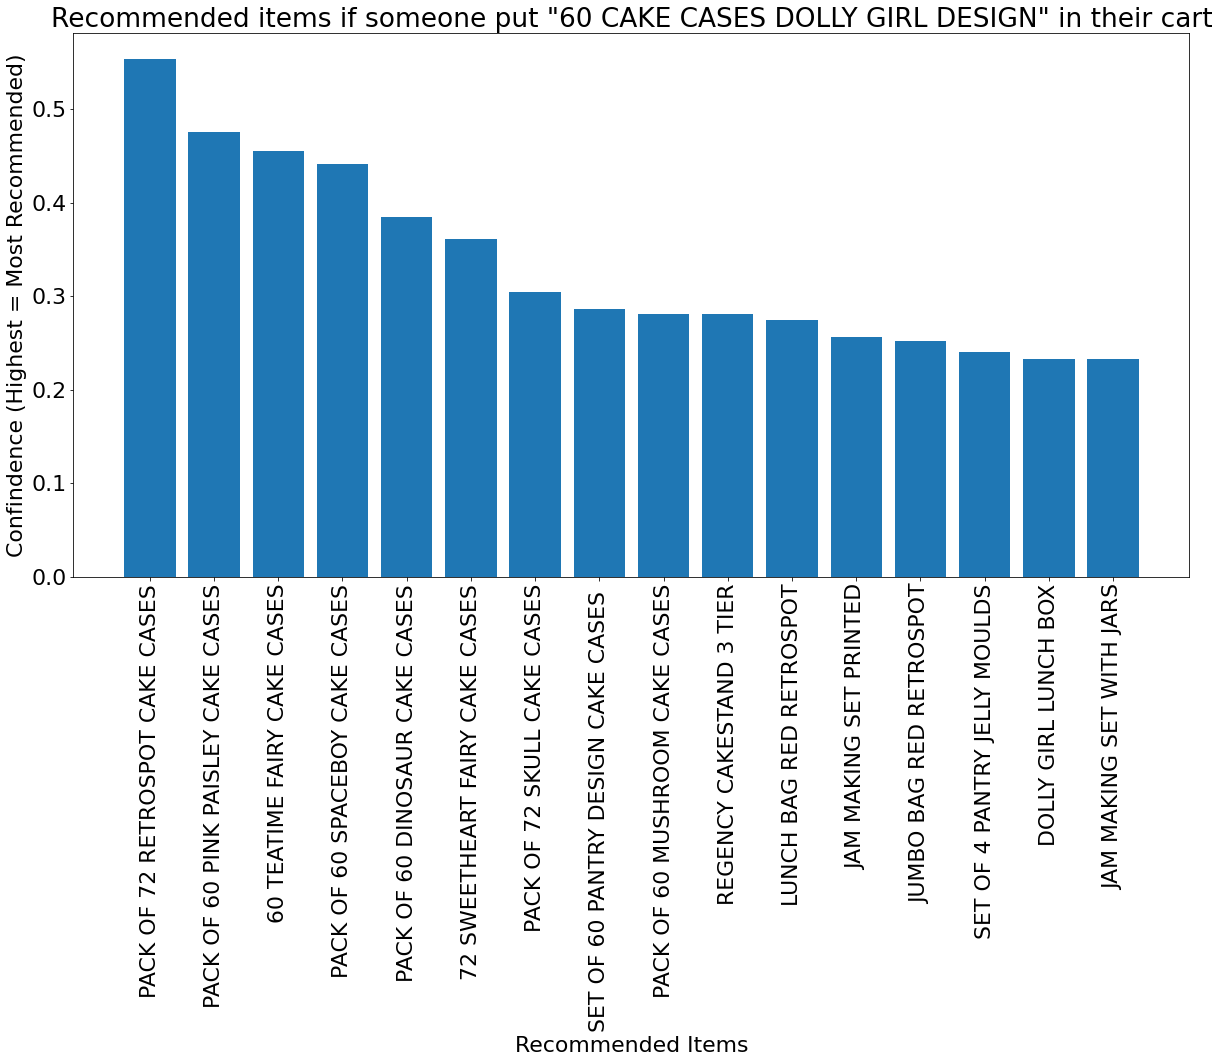

In [ ]:
recommend_list = recommend_list.truncate(0,19)

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})
plt.bar(recommend_list['consequents'],recommend_list['confidence'])
plt.title('Recommended items if someone put "'+ list(item_in_cart)[0] + '" in their cart')
plt.xlabel('Recommended Items')
plt.ylabel('Confindence (Highest = Most Recommended)')
plt.xticks(rotation=90)
plt.show()